In [22]:
pip install fastf1

In [23]:
!pip install xgboost

In [24]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [25]:
import os
os.makedirs("f1_cache", exist_ok=True)
fastf1.Cache.enable_cache("f1_cache")


In [26]:
# load the 2024 Barcelona session data
session_2024 = fastf1.get_session(2024, 10, "R")
session_2024.load()
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

In [27]:
# convert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

In [28]:
# aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

In [29]:
# quali data from Barcelona GP 2025
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [
        71.848,  # VER (1:11.848)
        71.755,  # NOR (1:11.755)
        71.546,  # PIA (1:11.546)
        71.849,  # RUS (1:11.848)
        73.203,  # SAI (1:13.203)
        72.641,  # ALB (1:12.641)
        72.131,  # LEC (1:12.131)
        73.201,  # OCO (1:13.201)
        72.045,  # HAM (1:12.045)
        73.058,  # STR (1:13.058)
        72.199,  # GAS (1:12.199)
        72.284,  # ALO (1:12.284)
        73.190   # HUL (1:13.190)
    ]
})

In [30]:
# tire degradation calculation: calculate it by measuring how much lap times increase per lap on the same tire compound.
# Degradation (s/lap) = (FinalLapTime - InitialLapTime) / (LapCount - 1)

def calculate_tire_degradation(session):
    """Calculate median tire degradation per driver in seconds per lap"""
    try:
        laps = session_2024.laps.copy()
        required_cols = ['LapTime', 'Stint', 'Compound', 'Driver']
        if 'LapTimeSeconds' not in laps.columns:
            laps = laps[pd.notnull(laps['LapTime'])]
            laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

        valid_laps = laps[
            (laps['Stint'].notna()) &
            (laps['Compound'].notna()) &
            (laps['LapTimeSeconds'].notna()) &
            (laps['LapTimeSeconds'] > 60)
        ].copy()

        if valid_laps.empty:
            print("No valid lap data found")
            return None

        degradation = {}

        for driver in valid_laps['Driver'].unique():
            driver_laps = valid_laps[valid_laps['Driver'] == driver]
            stints = driver_laps.groupby(['Stint', 'Compound'])
            stint_degradations = []

            for (stint, compound), stint_laps in stints:
                if len(stint_laps) < 5:
                    continue

                stint_laps = stint_laps.sort_values('LapNumber')
                stint_laps = stint_laps.reset_index(drop=True)
                base_time = stint_laps.iloc[0]['LapTimeSeconds']
                stint_laps['TimeDelta'] = stint_laps['LapTimeSeconds'] - base_time

                if stint_laps['TimeDelta'].isna().any() or stint_laps['TimeDelta'].std() < 0.1:
                    continue

                # Linear Regression to get degradation rate
                try:
                    X = stint_laps.index.values.reshape(-1, 1)
                    y = stint_laps['TimeDelta'].values

                    if len(np.unique(y)) > 1:
                        model = LinearRegression().fit(X, y)
                        degradation_rate = model.coef_[0]

                        if -0.5 < degradation_rate < 0.5:
                            stint_degradations.append(degradation_rate)
                except Exception as e:
                    print(f"Regression failed for {driver} stint {stint}: {str(e)}")
                    continue

            if stint_degradations:
                degradation[driver] = np.median(stint_degradations)

        return degradation

    except Exception as e:
        print(f"Error in degradation calculation: {str(e)}")
        return None

driver_degradation = calculate_tire_degradation(session_2024)
qualifying_2025["TireDegradation"] = qualifying_2025["Driver"].map(driver_degradation)


In [31]:
# get weather data for spain
API_KEY = "e649b58b58905cd519de6ca5745071b4"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=41.3412&lon=2.1540&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()
forecast_time = "2025-06-1 15:00:00"
forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20

In [32]:
# adjust qualifying time based on weather conditions
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]


In [33]:
# add constructor's data 2025:
team_points = {
    "McLaren": 319, "Mercedes": 147, "Red Bull": 143, "Williams": 54, "Ferrari": 142,
    "Haas": 26, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 22, "Alpine": 7
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Ferrari", "GAS": "Alpine", "ALO": "Aston Martin", "ALB": "Williams",
    "SAI": "Williams", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)

In [34]:
recent_form = {
    "VER": 17.000,   # Max Verstappen
    "NOR": 19.750,   # Lando Norris
    "PIA": 20.125,   # Oscar Piastri
    "RUS": 12.375,   # George Russell
    "SAI": 01.500,   # Carlos Sainz
    "ALB": 05.250,   # Alex Albon
    "LEC": 09.875,   # Charles Leclerc
    "OCO": 02.500,   # Esteban Ocon
    "HAM": 07.875,   # Lewis Hamilton
    "STR": 01.750,   # Lance Stroll
    "GAS": 01.750,   # Pierre Gasly
    "ALO": 00.000,   # Fernando Alonso
    "HUL": 00.750    # Nico Hulkenberg
}
scaler = StandardScaler()
qualifying_2025["RecentForm"] = qualifying_2025["Driver"].map(recent_form)
qualifying_2025["RecentForm"] = scaler.fit_transform(qualifying_2025[["RecentForm"]])

In [35]:
# merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["QualifyingTime"] = merged_data["QualifyingTime"]
merged_data["TireDegradation"] = merged_data["Driver"].map(driver_degradation)
merged_data["RecentForm"] = merged_data["Driver"].map(recent_form)


valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers]

In [36]:
# define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", "RecentForm", "TireDegradation",
]]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])
print(X)


    QualifyingTime  RainProbability  Temperature  TeamPerformanceScore  \
0           71.848                0           20              0.448276   
1           71.755                0           20              1.000000   
2           71.546                0           20              1.000000   
3           71.849                0           20              0.460815   
4           73.203                0           20              0.169279   
5           72.641                0           20              0.169279   
6           72.131                0           20              0.445141   
7           73.201                0           20              0.021944   
8           72.045                0           20              0.445141   
9           73.058                0           20              0.043887   
10          72.199                0           20              0.021944   
11          72.284                0           20              0.043887   
12          73.190                0   

In [37]:
# impute missing values for features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=999)


In [38]:
# train svr model
model1 = SVR(
        kernel='rbf',
        C=1.5,
        epsilon=0.1
    )
model1.fit(X_train, y_train)
merged_data["PredictedRaceTime SVR (s)"] = model1.predict(X_imputed)

# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime SVR (s)")
print("\n🏁 Predicted 2025 Barcelona GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime SVR (s)"]])
y_pred = model1.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")



🏁 Predicted 2025 Barcelona GP Winner 🏁

   Driver  PredictedRaceTime SVR (s)
2     PIA                  80.522119
1     NOR                  80.534406
0     VER                  80.622887
3     RUS                  80.775829
6     LEC                  80.861195
8     HAM                  80.928638
5     ALB                  81.019499
7     OCO                  81.112774
10    GAS                  81.133986
9     STR                  81.136771
4     SAI                  81.145174
12    HUL                  81.169571
11    ALO                  81.190591
Model Error (MAE): 0.33 seconds


In [39]:
# train knn model
model2 = KNeighborsRegressor(
        n_neighbors=3,
        weights='distance'
    )
model2.fit(X_train, y_train)
merged_data["PredictedRaceTime KNN (s)"] = model2.predict(X_imputed)

# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime KNN (s)")
print("\n🏁 Predicted 2025 Barcelona GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime KNN (s)"]])
y_pred = model2.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")


🏁 Predicted 2025 Barcelona GP Winner 🏁

   Driver  PredictedRaceTime KNN (s)
0     VER                  80.262169
1     NOR                  80.284508
2     PIA                  80.297330
8     HAM                  80.516554
3     RUS                  80.615062
6     LEC                  80.887735
10    GAS                  81.164123
7     OCO                  81.302400
12    HUL                  81.330338
11    ALO                  81.410647
4     SAI                  81.602978
9     STR                  81.810516
5     ALB                  82.257125
Model Error (MAE): 0.45 seconds


In [40]:
# train gradient boosting regressor model
model3 = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.8,  # prevent overfitting
        colsample_bytree=0.7,
        reg_alpha=0.5,
        random_state=999
    )
model3.fit(X_train, y_train)
merged_data["PredictedRaceTime XGB (s)"] = model3.predict(X_imputed)

# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime XGB (s)")
print("\n🏁 Predicted 2025 Barcelona GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime XGB (s)"]])
y_pred = model3.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")


🏁 Predicted 2025 Barcelona GP Winner 🏁

   Driver  PredictedRaceTime XGB (s)
1     NOR                  80.516975
2     PIA                  80.516975
0     VER                  80.522179
3     RUS                  80.550392
6     LEC                  80.605904
8     HAM                  80.608124
10    GAS                  81.188385
7     OCO                  81.299088
12    HUL                  81.326630
11    ALO                  81.395180
4     SAI                  81.472336
5     ALB                  81.770714
9     STR                  81.772346
Model Error (MAE): 0.30 seconds


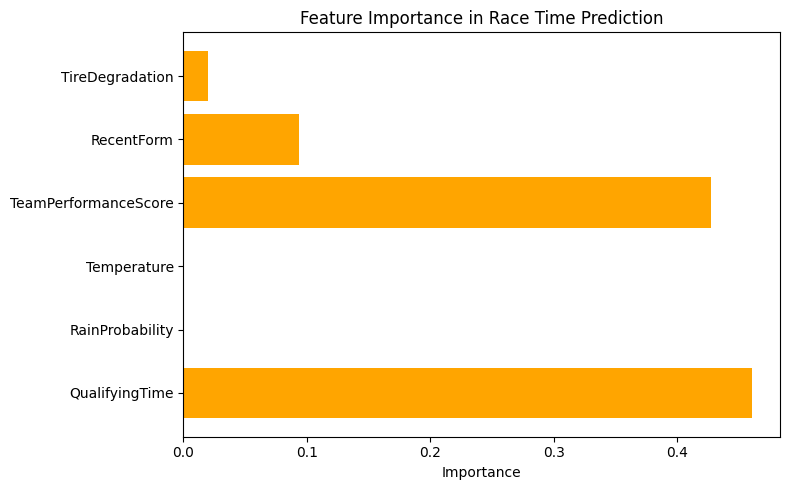

In [41]:
# Plot feature importances
feature_importance = model3.feature_importances_
features = X.columns
plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color='orange')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()

In [42]:
# sort results and get top 3
final_results = merged_data.sort_values("PredictedRaceTime SVR (s)").reset_index(drop=True)
podium = final_results.loc[:4, ["Driver", "PredictedRaceTime SVR (s)"]]

print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']}")
print(f"🥈 P2: {podium.iloc[1]['Driver']}")
print(f"🥉 P3: {podium.iloc[2]['Driver']}")



🏆 Predicted in the Top 3 🏆
🥇 P1: PIA
🥈 P2: NOR
🥉 P3: VER


In [43]:
"""
The predictions generated by the SVR model closely mirrored the actual race results, with the top 5 drivers predicted by the model (PIA, NOR, VER, RUS, LEC) matching the final top 5 finishers.
However, one significant exception was Max Verstappen, who was initially predicted to finish P5. Due to a 10-second time penalty incurred during the race,
his final standing dropped to P10, highlighting how unforeseen race-day events can influence outcomes beyond the model's scope.

This code is inspired by Mariana Antaya
"""

"\nThe predictions generated by the SVR model closely mirrored the actual race results, with the top 5 drivers predicted by the model (PIA, NOR, VER, RUS, LEC) matching the final top 5 finishers. \nHowever, one significant exception was Max Verstappen, who was initially predicted to finish P5. Due to a 10-second time penalty incurred during the race, \nhis final standing dropped to P10, highlighting how unforeseen race-day events can influence outcomes beyond the model's scope.\n\nThis code is inspired by Mariana Antaya\n"